In [3]:
import pandas as pd
import numpy as np
import spotipy
import matplotlib.pyplot as plt
import datetime
import dotenv
import json
import tqdm
import os
from collections import Counter
from calendar import Calendar, monthrange
c = Calendar()
dotenv.load_dotenv()

True

In [85]:
SPOTIFY_API_KEY = os.getenv('SPOTIFY_API_KEY')
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
spotify_search_url = 'https://api.spotify.com/v1/search?q={q}&type={type}'
spotify_headers = {"Accept": "application/json", "Authorization":"Bearer " + SPOTIFY_API_KEY, "Content-Type": "application/json"}
client_credentials_manager = spotipy.SpotifyClientCredentials(SPOTIFY_CLIENT_ID, SPOTIFY_API_KEY)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
master_df = pd.read_csv("master_df.csv", parse_dates = [6] )


In [86]:
master_df.columns

Index(['offline_timestamp', 'conn_country', 'master_metadata_album_album_name',
       'username', 'spotify_track_uri', 'reason_start', 'ts',
       'master_metadata_album_artist_name', 'offline', 'spotify_episode_uri',
       'platform', 'reason_end', 'user_agent_decrypted', 'ms_played',
       'master_metadata_track_name', 'ip_addr_decrypted', 'skipped',
       'incognito_mode', 'episode_show_name', 'episode_name', 'shuffle'],
      dtype='object')

### Queries a la API de Spotify

En mis datos de Spotify no hay información de generos, por ende la voy a buscar a la API para desarrolladores que exhibe Spotify. La información de género se asocia al artista, no a la canción. No hay id de artista, por ende tengo que buscarlo.  
Por otro lado también busco info sobre los tracks, para hacer otros analisis. 
Son dos solicitudes distintas, que tardan mucho tiempo. Guardo la info que se obtiene en un archivo JSON con la idea de no tener que repetirlas.

*Dependen de tener los datos de desarrollador de Spotify, que se guardan en un archivo .env con el siguiente formato*

```bash
SPOTIFY_API_KEY=NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
SPOTIFY_CLIENT_ID=NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
```

In [87]:
responses_tracks = {}
errors_tracks = {}
tracks_filename = "track_data.json"
if not os.path.exists(tracks_filename):
	for track_name in set(master_df.spotify_track_uri):
		if track_name != None:
			try:
				responses_tracks[track_name] = spotify.track(track_name)
			except Exception as e:
				errors_tracks[track_name] = {"response" : responses_tracks, "error": e}
	with open(tracks_filename , "w") as file:
		json.dump(responses_tracks, file)
else:
    
	 with open(tracks_filename) as file:
	    responses_tracks = json.load(file)
	
# tracks_filename = "data_tracks.json"
# with open(tracks_filename , "w") as file:
# 	json.dump(responses_tracks, file)


In [11]:
filename = "data.json"
if not os.path.exists(filename):
    responses = {}
    for artist in set(master_df.master_metadata_album_artist_name):
        try:
            response = spotify.search(artist, type='artist')
            responses[artist] = response      
        except Exception as e:
            print(e)
            print(response)
    with open(filename , "w") as file:
	    json.dump(responses, file)
else:
    
	 with open(filename) as file:
	    responses = json.load(file)



list index out of range
{'artists': {'href': 'https://api.spotify.com/v1/search?query=Calvin+Piano+Boyce&type=artist&offset=0&limit=10', 'items': [], 'limit': 10, 'next': None, 'offset': 0, 'previous': None, 'total': 0}}
list index out of range
{'artists': {'href': 'https://api.spotify.com/v1/search?query=TRAZANTE&type=artist&offset=0&limit=10', 'items': [], 'limit': 10, 'next': None, 'offset': 0, 'previous': None, 'total': 0}}
list index out of range
{'artists': {'href': 'https://api.spotify.com/v1/search?query=Burial%2C+Four+Tet%2C+Thom+Yorke&type=artist&offset=0&limit=10', 'items': [], 'limit': 10, 'next': None, 'offset': 0, 'previous': None, 'total': 0}}
2977 2977


### Analizar los missings de las respuestas

Quiero ver cuales artistas no aparecen (`nf`), y `ls` esta medio al pedo, luego eliminar

In [6]:
ls = []
nf = []
for artist, data in responses.items():
	try:
		ls.append(len(data["artists"]["items"][0]["genres"]))
	except IndexError:
		nf.append(artist)
longest_genre_list = max(ls)

### Parseo basico

A partir de los datos de la API de Spotify 
genero un dict (`d2`) con la correspondencia Artista => Generos.


In [7]:
d2 = {}
for artist, data in responses.items():
	arr = np.empty(longest_genre_list,  dtype= "<U100") 
	if artist not in nf:
		# genres = data["artists"]["items"][0]["genres"]
		artist_query_response = data["artists"]["items"]
		query = {result["popularity"] : (result["genres"], result["name"]) for result in artist_query_response if result["name"] == artist}
		if query == {}:
			continue
		genres, artist_name = query[max(query.keys())]
		arr[0:len(genres)] = genres
		d2[artist_name] = arr
df = pd.DataFrame(d2)
df.index = ["genero_{}".format(n) for n in range(longest_genre_list)]
genre_list = df.to_numpy().flatten()
genre_list_clean = genre_list[genre_list != ""]

### Generos por dia

A partir de los datos de los artistas reproducidos en cada dia, puedo calcular que cantidad de reproducciones por genero tengo cada dia. Supongo que todos los generos de lx artista se escuchan por igual. Queda todo en el dict `dateg`

In [8]:
dateg = {}
failed = []
gdf = master_df.groupby([master_df.ts.dt.date, master_df.master_metadata_album_artist_name])
dg = gdf.offline_timestamp.count().to_dict()
for ((date, artist_date), count) in dg.items():
	try:
		gv = d2[artist_date]
		gv = list(gv[gv != ""]) * count
		try:
			dateg[date] += gv
		except KeyError:
			dateg[date] = gv 
	except KeyError:
		failed.append(artist_date)

### Normalizacion por mes

Para tener una idea de el progreso relativo por genero, normalizo las reproducciones por la cantidad de playbacks durante ese mes. Dataframes importantes : 
 - `dfdates` : Escuchas por genero por dia.
 - `df_aux` : Igual, transpuesto. Con una columna `date` para poder hacer groupby.
 - `fc_mes` : Escuchas por mes.
 - `df_norm` :  Escuchas por genero por dia. Normalizadas por escucha por mes.

In [33]:
cnts_dateg = {date: Counter(genres) for date, genres in dateg.items()}
dfdates = pd.DataFrame(cnts_dateg)
df_aux = dfdates.T
df_aux["date"]= pd.to_datetime(df_aux.index)
coef_mes = df_aux.groupby(df_aux.date.dt.to_period("M")).sum().replace({0 : 1})
fc_mes = coef_mes.T.sum()
fc_mes.name = "playbacks"
df_norm = dfdates.T
rpts = 0
d = {}
for (index, cnt) in fc_mes.items():
	rng = pd.date_range(index.start_time, index.end_time)
	for val in rng:
		d[val.to_pydatetime().date()] = cnt
for (n,row) in df_norm.iterrows():
	df_norm.loc[n,:] /= d[n] 

/tmp/ipykernel_81910/3475398265.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  coef_mes = df_aux.groupby(df_aux.date.dt.to_period("M")).sum().replace({0 : 1})


### Plot de genero por mes

/tmp/ipykernel_81910/634268541.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x_mes = plot_df.groupby(plot_df.date.dt.to_period("M")).sum()


Text(0, 0.5, 'Frecuencia relativa')

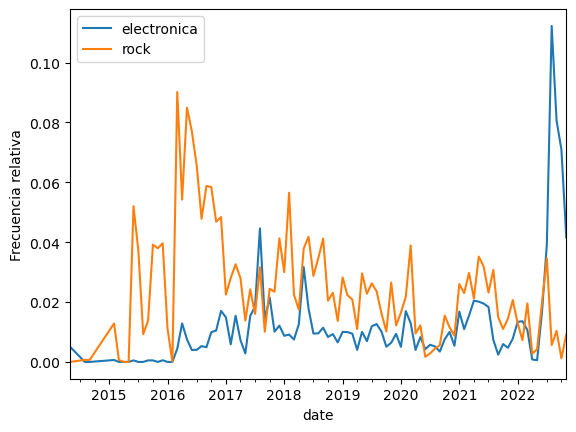

In [64]:
plot_df = df_norm.copy(deep = True).fillna(0)
plot_df["date"] = df_aux["date"]
x_mes = plot_df.groupby(plot_df.date.dt.to_period("M")).sum()
x_mes[["electronica","rock"]].plot()
plt.ylabel("Frecuencia relativa")